In [1]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic


def calculate_monthly_distances(data, vessel_col, date_col, lat_col, lon_col):
    """
    Calcula las distancias recorridas mensualmente por cada embarcación.

    Parámetros:
    - data: DataFrame con los datos.
    - vessel_col: Nombre de la columna que contiene los nombres de las embarcaciones.
    - date_col: Nombre de la columna que contiene las fechas.
    - lat_col: Nombre de la columna que contiene las latitudes.
    - lon_col: Nombre de la columna que contiene las longitudes.

    Retorna:
    - DataFrame con las distancias recorridas mensualmente por cada embarcación.
    """
    # Asegurarse de que las columnas de longitud y latitud sean del tipo float
    data[lon_col] = data[lon_col].astype(float)
    data[lat_col] = data[lat_col].astype(float)

    # Convertir la columna de fecha y hora al tipo datetime, ignorando errores
    data[date_col] = pd.to_datetime(data[date_col], format='%d/%m/%Y %H:%M', errors='coerce')

    # Eliminar filas con fechas inválidas
    data = data.dropna(subset=[date_col])

    # Extraer año y mes de la columna de fecha
    data['Anio'] = data[date_col].dt.year
    data['Mes'] = data[date_col].dt.month

    # Ordenar los datos por embarcación y fecha
    data = data.sort_values(by=[vessel_col, date_col])

    # Función para calcular la distancia entre dos puntos geográficos
    def haversine_distance(row):
        if pd.isna(row['prev_lat']) or pd.isna(row['prev_lon']):
            return 0
        else:
            return geodesic((row['prev_lat'], row['prev_lon']), (row[lat_col], row[lon_col])).kilometers

    # Calcular las distancias
    data['prev_lat'] = data.groupby(vessel_col)[lat_col].shift(1)
    data['prev_lon'] = data.groupby(vessel_col)[lon_col].shift(1)
    data['distance_km'] = data.apply(haversine_distance, axis=1)

    # Sumar las distancias por mes y embarcación
    data['YearMonth'] = data['Anio'].astype(str) + '-' + data['Mes'].astype(str).str.zfill(2)
    monthly_distances = data.groupby([vessel_col, 'YearMonth'])['distance_km'].sum().reset_index()

    return monthly_distances

In [2]:
import pandas as pd
import glob
import os

# Especifica la ruta de la carpeta que contiene los archivos CSV
carpeta_csv = 'archivos_filtrados'  # Cambia esta ruta a la de tu carpeta

# Usa glob para encontrar todos los archivos CSV en la carpeta
archivos_csv = glob.glob(os.path.join(carpeta_csv, '*.csv'))

# Crea una lista para almacenar cada DataFrame individual
dataframes = []

# Diccionario de renombre de columnas
columnas_renombradas = {
    'Nombre': 'Nombre_Embarcacion',
    'Puerto_Base': 'Puerto Base',
    'Razón Social': 'Permisionario o concesionario',
    'Pemisionario o Concesionario': 'Permisionario o concesionario'
}

# Itera sobre la lista de archivos CSV y lee cada uno en un DataFrame
for archivo in archivos_csv:
    df = pd.read_csv(archivo)
    
    # Renombrar las columnas según el diccionario
    df.rename(columns=columnas_renombradas, inplace=True)
    
    # Eliminar la columna 'Unnamed: 9' si existe
    if 'Unnamed: 9' in df.columns:
        df.drop(columns=['Unnamed: 9'], inplace=True)
    
    dataframes.append(df)

# Concatena todos los DataFrames en uno solo
df_concatenado = pd.concat(dataframes, ignore_index=True)

# Guarda el DataFrame concatenado en un nuevo archivo CSV
df_concatenado.to_csv('vms_concatenado.csv', index=False)  # Cambia esta ruta y nombre de archivo según tus necesidades

print(f'Se han unido {len(archivos_csv)} archivos CSV en un único DataFrame y se ha guardado como csv_concatenado.csv')


Se han unido 136 archivos CSV en un único DataFrame y se ha guardado como csv_concatenado.csv


In [4]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_monthly_distances(data, vessel_col, date_col, lat_col, lon_col):
    """
    Calculates the monthly distances traveled and operation hours by each vessel.

    Parameters:
    - data: DataFrame with the data.
    - vessel_col: Name of the column containing the vessel names.
    - date_col: Name of the column containing the dates.
    - lat_col: Name of the column containing the latitudes.
    - lon_col: Name of the column containing the longitudes.

    Returns:
    - DataFrame with the monthly distances traveled and operation hours by each vessel.
    """
    # Ensure that the longitude and latitude columns are of type float
    data = data.copy()  # Make a copy of the DataFrame to avoid SettingWithCopyWarning
    data[lon_col] = data[lon_col].astype(float)
    data[lat_col] = data[lat_col].astype(float)

    # Convert the date column to datetime, ignoring errors
    data[date_col] = pd.to_datetime(data[date_col], format='%d/%m/%Y %H:%M:%S', errors='coerce')

    # Drop rows with invalid dates
    data = data.dropna(subset=[date_col])

    # Extract year and month from the date column
    data['Year'] = data[date_col].dt.year
    data['Month'] = data[date_col].dt.month

    # Sort data by vessel and date
    data = data.sort_values(by=[vessel_col, date_col])

    # Create a geometry column from longitude and latitude columns
    data['geometry'] = [Point(xy) for xy in zip(data[lon_col], data[lat_col])]
    gdf = gpd.GeoDataFrame(data, geometry='geometry')

    # Calculate the distance between consecutive points in time for each vessel
    def calculate_distance(row):
        if pd.isnull(row['Latitud_prev']) or pd.isnull(row['Longitud_prev']):
            return 0
        return geodesic((row['Latitud'], row['Longitud']), (row['Latitud_prev'], row['Longitud_prev'])).km

    # Shift the coordinates and time to get the previous point and time
    gdf['Latitud_prev'] = gdf.groupby(vessel_col)[lat_col].shift()
    gdf['Longitud_prev'] = gdf.groupby(vessel_col)[lon_col].shift()
    gdf['Fecha_prev'] = gdf.groupby(vessel_col)[date_col].shift()

    # Apply the distance calculation
    gdf['Distancia_km'] = gdf.apply(calculate_distance, axis=1)

    # Calculate the time difference in hours
    gdf['Tiempo_horas'] = (gdf[date_col] - gdf['Fecha_prev']).dt.total_seconds() / 3600

    # Replace NaN in distance and time columns with 0
    gdf['Distancia_km'] = gdf['Distancia_km'].fillna(0)
    gdf['Tiempo_horas'] = gdf['Tiempo_horas'].fillna(0)

    # Create a year-month column
    gdf['YearMonth'] = gdf[date_col].dt.to_period('Y')

    # Verify distribution of dates
    print(gdf['YearMonth'].value_counts().sort_index())

    # Calculate the total distance traveled and hours at sea monthly for each vessel
    monthly_distance_time = gdf.groupby([vessel_col, 'YearMonth']).agg({
        'Distancia_km': 'sum',
        'Tiempo_horas': 'sum'
    }).reset_index()

    # Convert 'YearMonth' to datetime for proper sorting in plots
    monthly_distance_time['YearMonth'] = monthly_distance_time['YearMonth'].dt.to_timestamp()

    # Calculate the monthly averages of distance traveled and time at sea
    mean_distance = monthly_distance_time.groupby('YearMonth')['Distancia_km'].mean()
    mean_hours = monthly_distance_time.groupby('YearMonth')['Tiempo_horas'].mean()

    # Plot the boxplots in a single figure
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), dpi=300)

    # Plot a boxplot of the monthly distance traveled for all vessels
    sns.boxplot(ax=axes[0], x='YearMonth', y='Distancia_km', data=monthly_distance_time, showfliers=False)
    #axes[0].plot(mean_distance.index.astype(str), mean_distance.values, color='red', marker='o', linestyle='-', linewidth=2, label='Mean')
    axes[0].set_title('a)', loc='left')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Distance Traveled (km)')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True)
    axes[0].legend()

    # Plot a boxplot of the monthly operation hours for all vessels
    sns.boxplot(ax=axes[1], x='YearMonth', y='Tiempo_horas', data=monthly_distance_time, showfliers=False)
    #axes[1].plot(mean_hours.index.astype(str), mean_hours.values, color='red', marker='o', linestyle='-', linewidth=2, label='Mean')
    axes[1].set_title('b)', loc='left')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Mean operation hours')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True)
    axes[1].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

    return monthly_distance_time, mean_distance, mean_hours


In [3]:
vms_result = calculate_monthly_distances(df_concatenado, 'Nombre_Embarcacion', 'Fecha', 'Latitud', 'Longitud')


print(vms_result.head(10))

C:\Users\ricar\AppData\Local\Temp\ipykernel_33520\4217584639.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Anio'] = data[date_col].dt.year
C:\Users\ricar\AppData\Local\Temp\ipykernel_33520\4217584639.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Mes'] = data[date_col].dt.month


  Nombre_Embarcacion YearMonth  distance_km
0      24 DE FEBRERO   2018-04  1229.567610
1      24 DE FEBRERO   2018-05  1471.454850
2      24 DE FEBRERO   2020-04   111.970054
3      24 DE FEBRERO   2020-05   318.935216
4      24 DE FEBRERO   2020-08   448.251787
5      24 DE FEBRERO   2020-09   227.861655
6      24 DE FEBRERO   2021-01   877.308971
7            ABRAHAM   2018-05   346.235199
8            ABRAHAM   2018-06   849.326818
9            ABRAHAM   2020-01   633.105457


In [15]:
new_result

(     Nombre_Embarcacion  YearMonth  Distancia_km  Tiempo_horas
 0         24 DE FEBRERO 2018-01-01   2701.022461   1221.016667
 1         24 DE FEBRERO 2020-01-01   1107.018712  19942.183333
 2         24 DE FEBRERO 2021-01-01    877.308971   3258.316667
 3               ABRAHAM 2018-01-01   1195.562016    452.000000
 4               ABRAHAM 2020-01-01   1702.475885  21460.816667
 ...                 ...        ...           ...           ...
 3252            ZORRO I 2023-01-01    520.431570   8852.333333
 3253           ZORRO II 2018-01-01     52.601088     14.433333
 3254           ZORRO II 2021-01-01    139.436110  27178.716667
 3255           ZORRO II 2022-01-01    535.004055   5240.433333
 3256           ZORRO II 2023-01-01     57.839665  12766.950000
 
 [3257 rows x 4 columns],
 YearMonth
 2018-01-01    4335.373763
 2019-01-01    4388.532941
 2020-01-01    4060.904216
 2021-01-01    3182.056520
 2022-01-01    3625.449121
 2023-01-01    1183.242150
 Name: Distancia_km, dtype: flo

YearMonth
2018    1249542
2019    1213190
2020    1036060
2021     895497
2022     678822
2023     168833
Freq: Y-DEC, Name: count, dtype: int64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


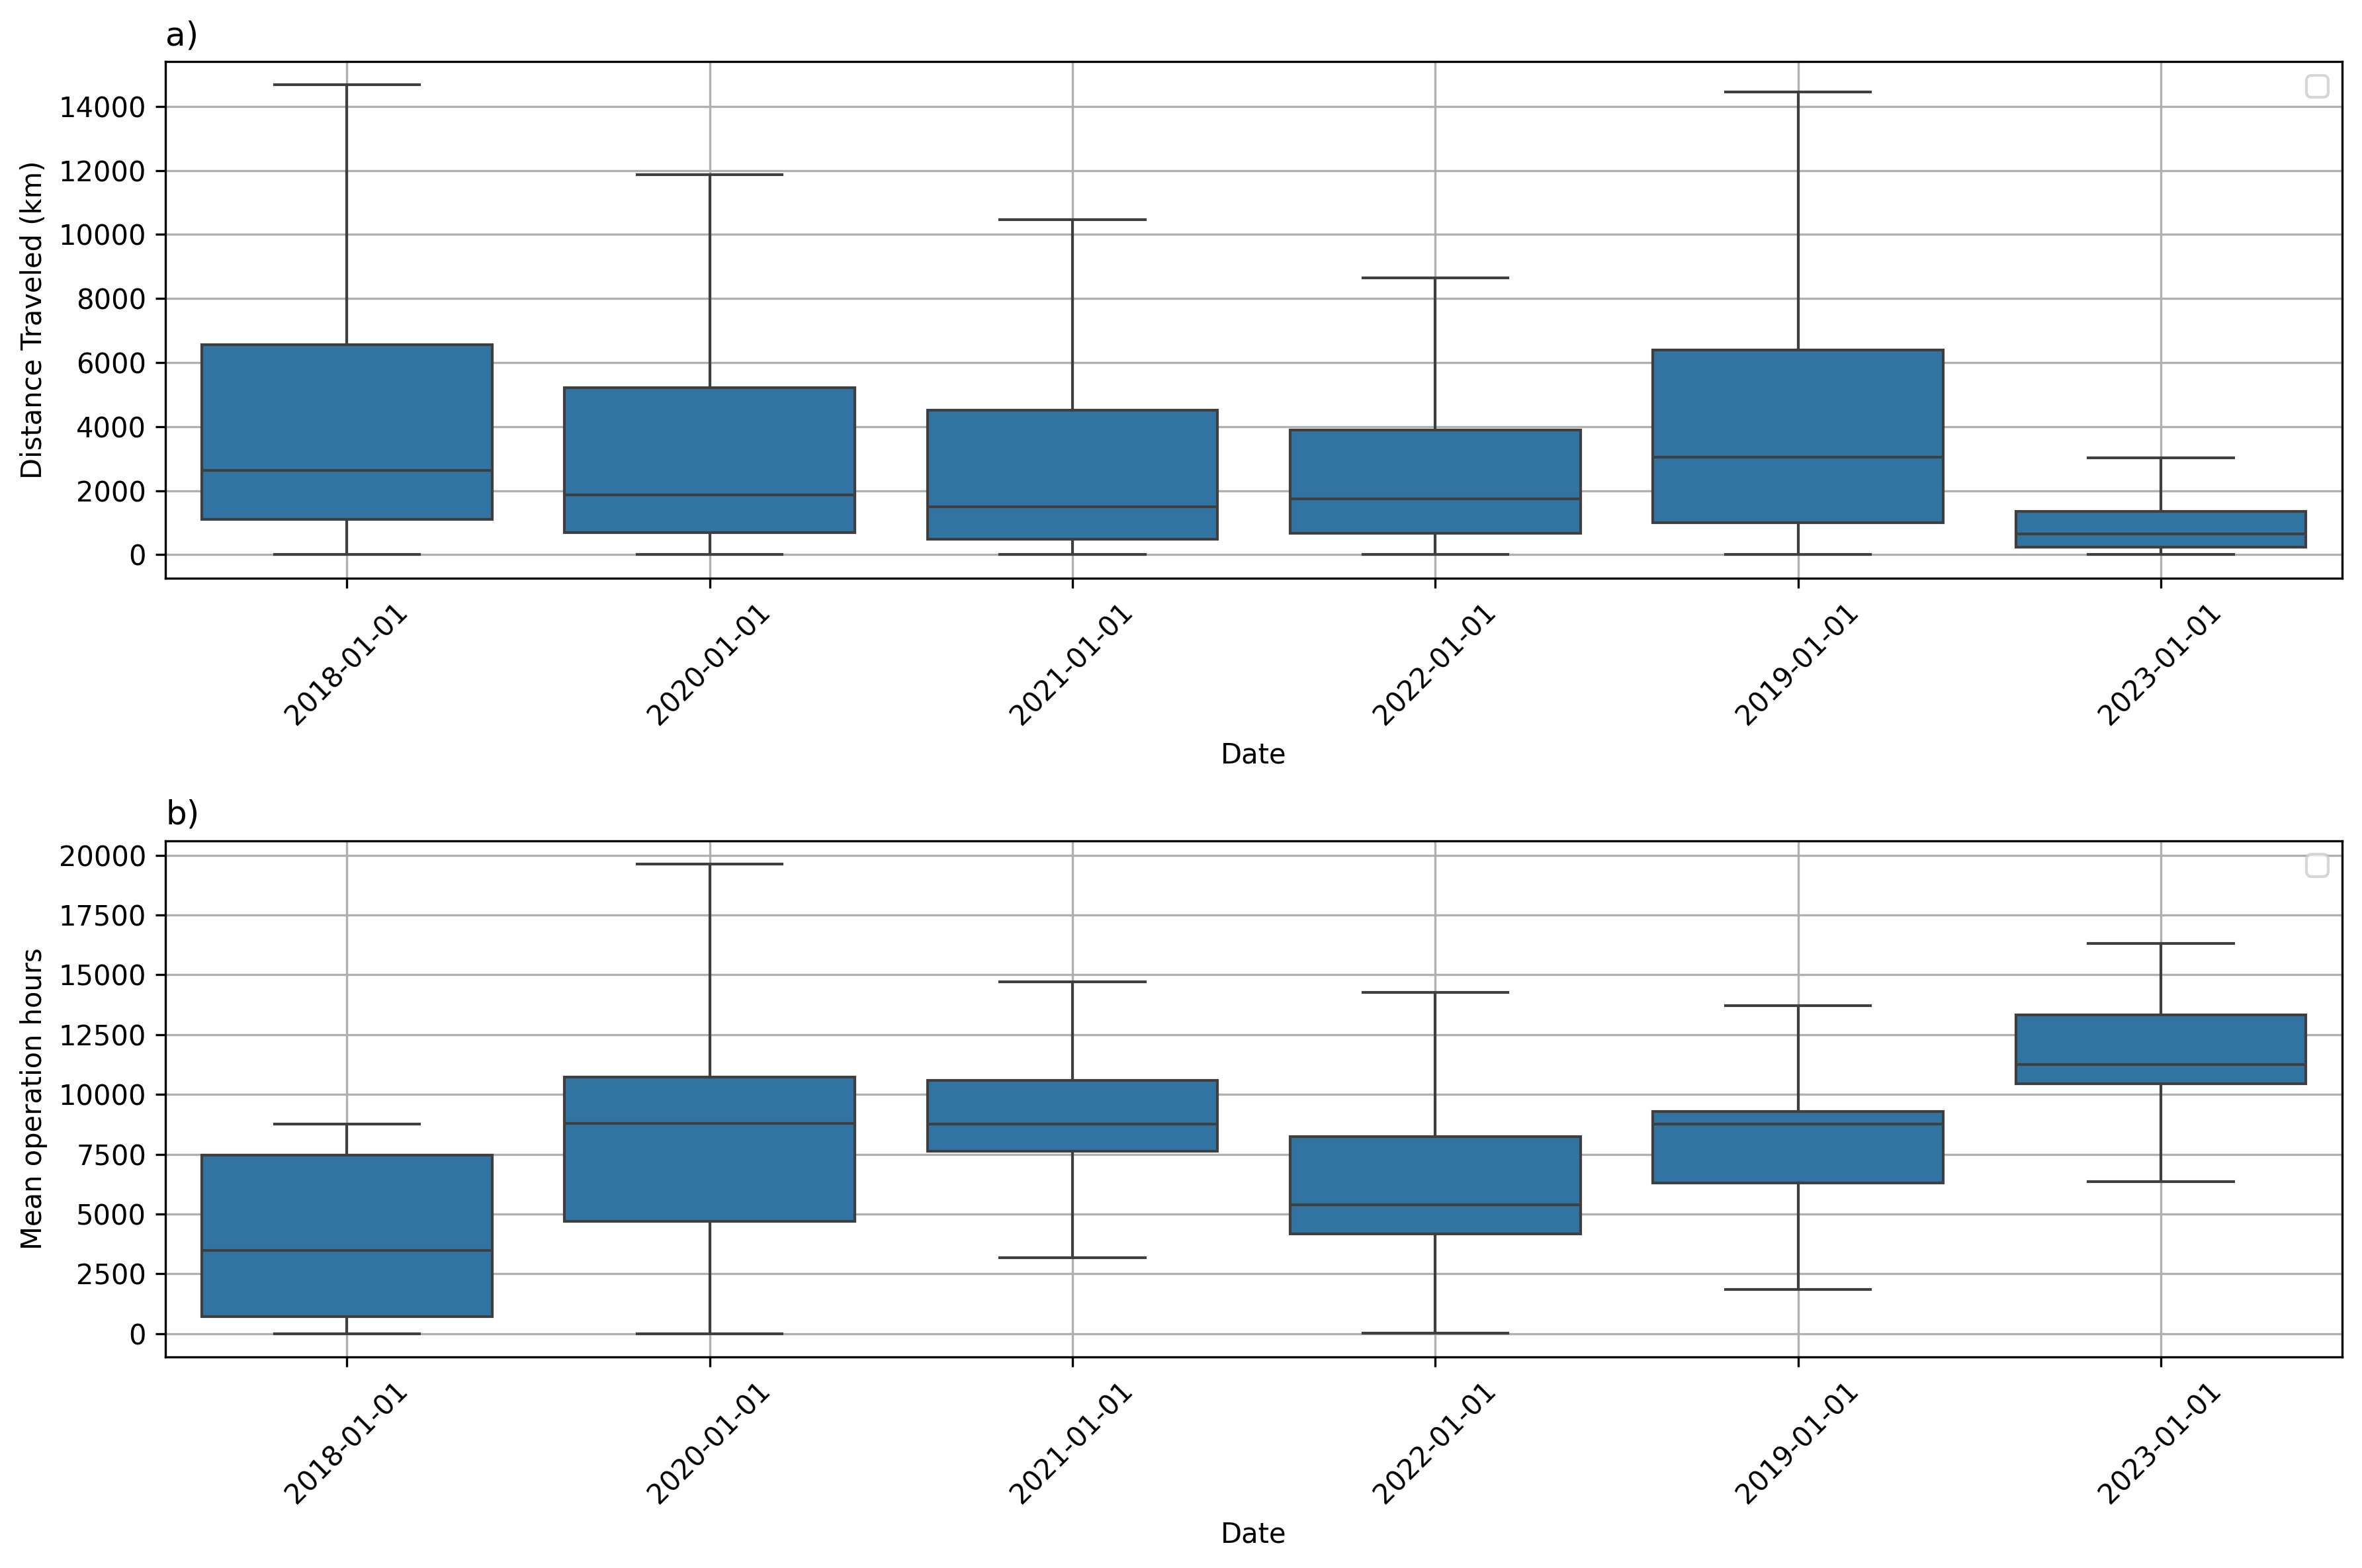

In [5]:
# Aplicar la función con los nombres de columnas apropiados
vessel_col = 'Nombre_Embarcacion'
date_col = 'Fecha'
lat_col = 'Latitud'
lon_col = 'Longitud'

new_result = calculate_monthly_distances(df_concatenado, vessel_col, date_col, lat_col, lon_col)

# Mostrar el resultado

YearMonth
2018    1249542
2019    1213190
2020    1036060
2021     895497
2022     678822
2023     168833
Freq: Y-DEC, Name: count, dtype: int64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


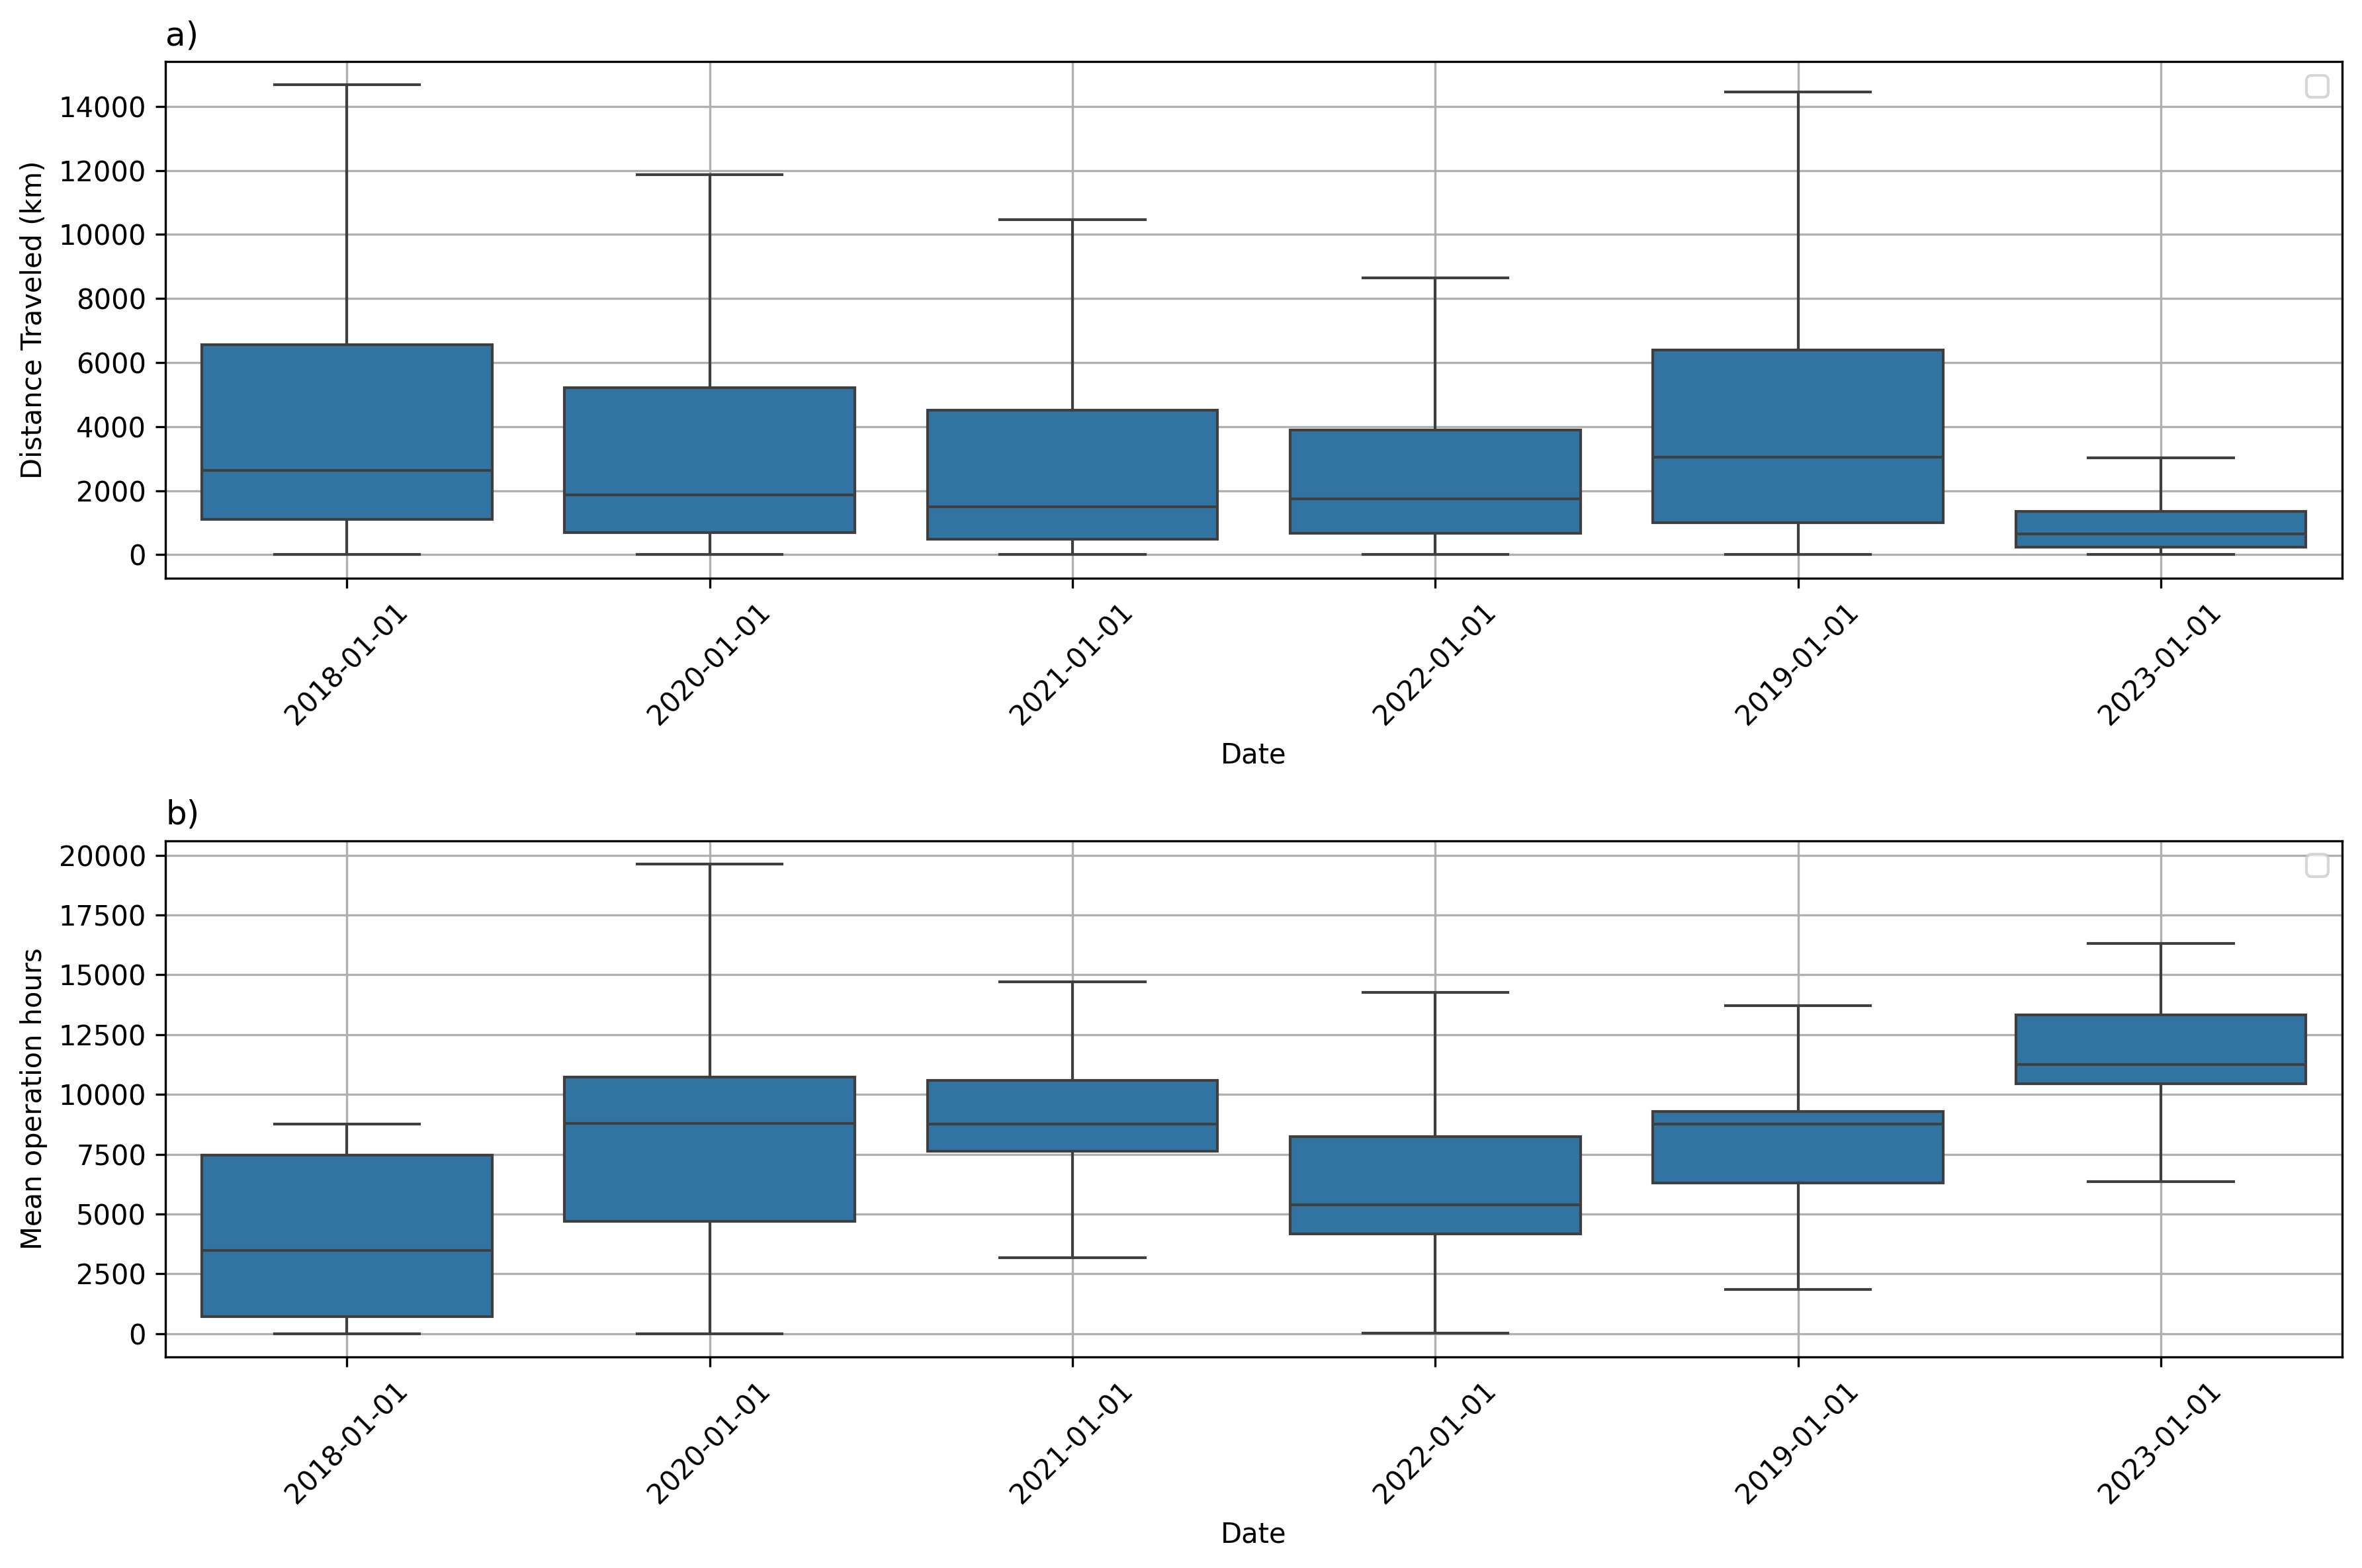

In [22]:
monthly_distance_time, mean_distance, mean_hours =  calculate_monthly_distances(df_concatenado, vessel_col, date_col, lat_col, lon_col)
 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


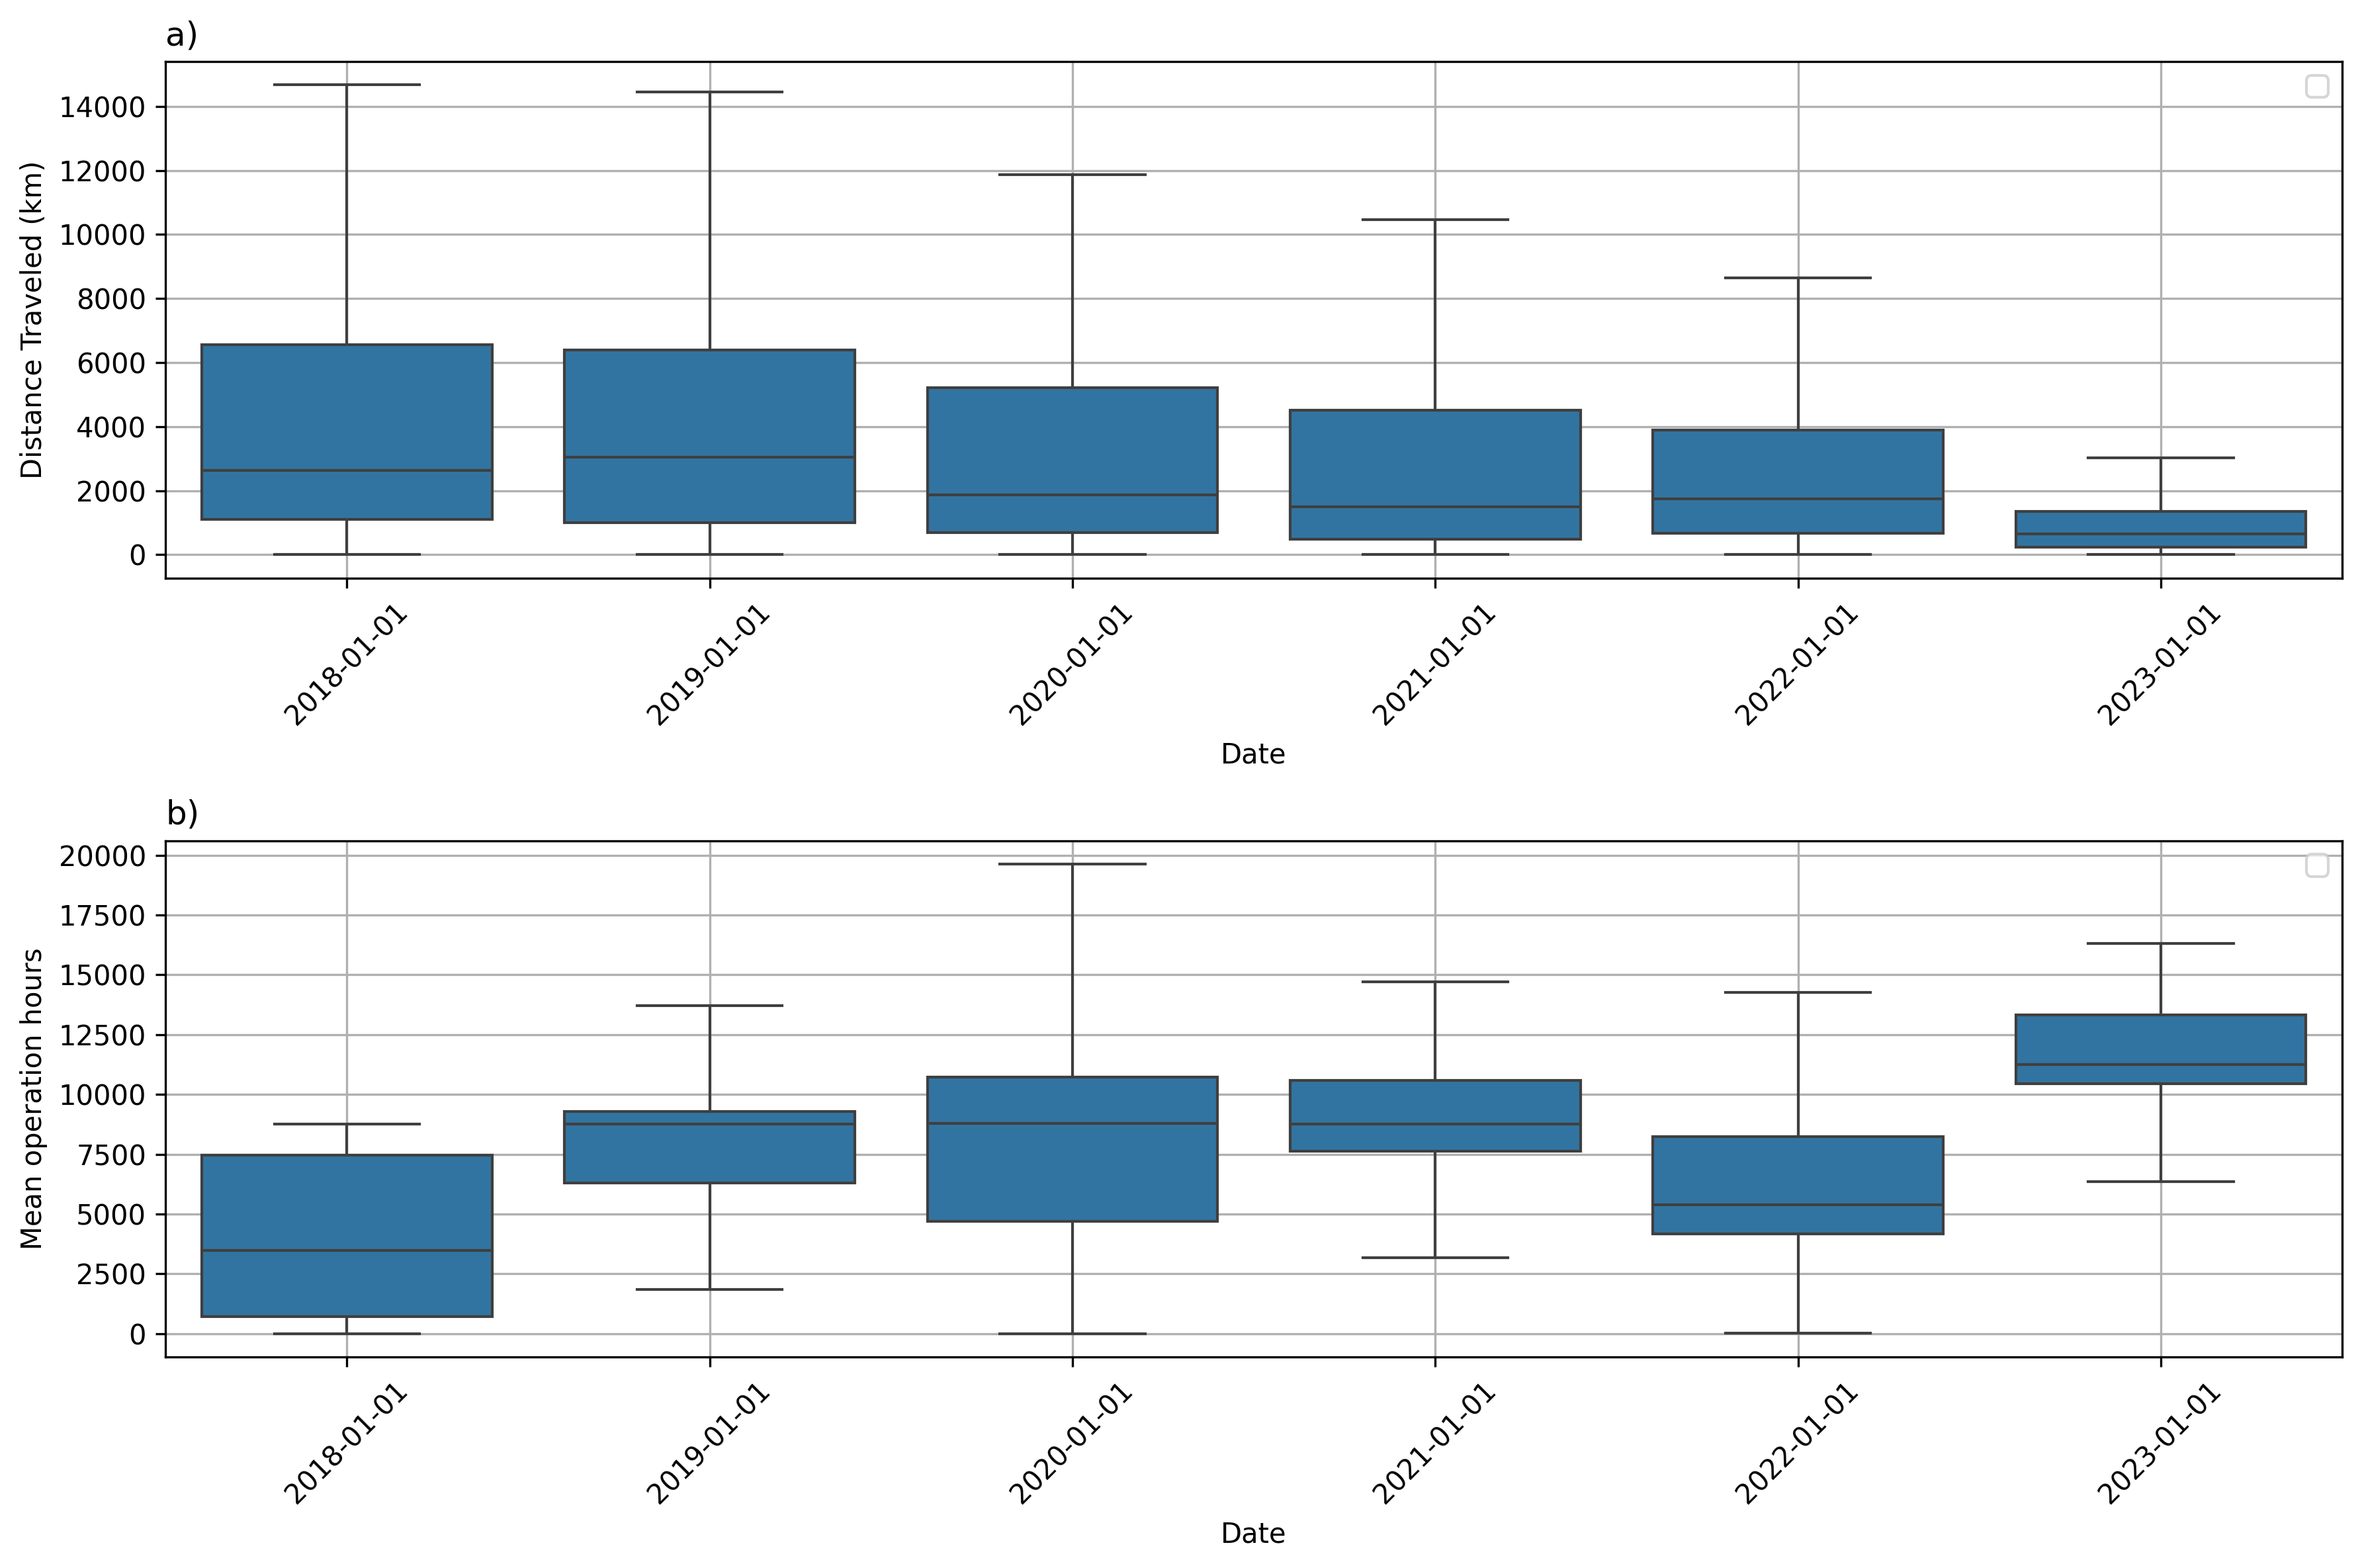

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Asegurar que 'YearMonth' está en formato datetime
monthly_distance_time['YearMonth'] = pd.to_datetime(monthly_distance_time['YearMonth'])

# Ordenar los datos por 'YearMonth'
monthly_distance_time = monthly_distance_time.sort_values('YearMonth')

# Calcular las medias de distancia recorrida y horas de operación
mean_distance = monthly_distance_time.groupby('YearMonth')['Distancia_km'].mean()
mean_hours = monthly_distance_time.groupby('YearMonth')['Tiempo_horas'].mean()

# Crear los gráficos
fig, axes = plt.subplots(2, 1, figsize=(12, 8), dpi=300)

# Gráfico de caja para la distancia mensual recorrida
sns.boxplot(ax=axes[0], x='YearMonth', y='Distancia_km', data=monthly_distance_time, showfliers=False)
#axes[0].plot(mean_distance.index, mean_distance.values, color='red', marker='o', linestyle='-', linewidth=2, label='Mean')
axes[0].set_title('a)', loc='left')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Distance Traveled (km)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)
axes[0].legend()

# Gráfico de caja para las horas de operación mensuales
sns.boxplot(ax=axes[1], x='YearMonth', y='Tiempo_horas', data=monthly_distance_time, showfliers=False)
#axes[1].plot(mean_hours.index, mean_hours.values, color='red', marker='o', linestyle='-', linewidth=2, label='Mean')
axes[1].set_title('b)', loc='left')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Mean operation hours')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)
axes[1].legend()

# Ajuste del layout
plt.tight_layout()
plt.show()

In [ ]:
df_concatenado['Puerto Base'].unique()

array(['LERMA', 'TUXPAN  VER.', 'FRONTERA  TAB.', 'PROGRESO', 'CELESTUN',
       'PROGRESO YUC', 'CAMPECHE  CAM.', 'CIUDAD DEL CARMEN (CAB.)',
       'TAMPICO', 'COATZACOALCOS  VER', 'SAN FRANCISCO', 'FRONTERA',
       'LERMA  CAM.', 'CIUDAD DEL CARMEN  CAM.', 'ALVARADO  VER.',
       'TUXPAN', 'DZILAM DE BRAVO', 'SAN FRANCISCO KOBEN',
       'CELESTUM  YUC.', 'CANCUN', 'CARMEN (CAB.)', 'CARMEN, EL',
       'PUERTO JUAREZ', 'VERACRUZ', 'VERACRUZ  VER.', 'CANCUN QROO',
       'MAZATLAN  SIN.', 'PUERTO JUAREZ  QROO', 'RIO LAGARTOS',
       'MERIDA YUC', 'TELCHAC PUERTO', 'MERIDA', 'PROGRESO, YUCATÁN',
       'YUCALPETÉN, YUCATÁN', 'PUERTO JUÁREZ, QUINTANA ROO',
       'CAMPECHE, CAMPECHE', 'TUXPAN, VERACRUZ', 'FRONTERA, TABASCO',
       'CELESTÚN, YUCATÁN', 'LERMA, CAMPECHE', 'TAMPICO, TAMAULIPAS',
       'CIUDAD DEL CARMEN, CAMPECHE', 'MAZATLÁN, SINALOA',
       'VERACRUZ, VERACRUZ', 'TELCHAC PUERTO, YUCATÁN',
       'DZILAM DE BRAVO, YUCATÁN'], dtype=object)

In [ ]:
lista= ['FRONTERA  TAB.', 'PROGRESO', 'CELESTUN','FRONTERA  TAB.', 'PROGRESO', 'CELESTUN','FRONTERA  TAB.', 'PROGRESO', 'CELESTUN','CIUDAD DEL CARMEN  CAM.','DZILAM DE BRAVO','CAMPECHE, CAMPECHE','FRONTERA, TABASCO', 'LERMA, CAMPECHE','CIUDAD DEL CARMEN, CAMPECHE']
data_vms = df_concatenado[df_concatenado['Puerto Base'].isin(lista)]

In [ ]:
data_vms['Fecha'] = pd.to_datetime(data_vms['Fecha'])

C:\Users\ricar\AppData\Local\Temp\ipykernel_26300\2316648349.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_vms['Fecha'] = pd.to_datetime(data_vms['Fecha'])


In [ ]:
data_vms_2017= data_vms[data_vms['Fecha'].dt.year==2017]
data_vms_2023= data_vms[data_vms['Fecha'].dt.year==2023]

In [ ]:
data_vms_2023

NameError: name 'data_vms_2013' is not defined

In [44]:
import pandas as pd

# Cargar los datos desde el archivo CSV
data_vms = pd.read_csv('vms_concatenado.csv',low_memory=False)

# Asegurarse de que la columna 'Fecha' es de tipo datetime
data_vms['Fecha'] = pd.to_datetime(data_vms['Fecha'],errors='coerce')
lista= ['FRONTERA  TAB.', 'PROGRESO', 'CELESTUN','FRONTERA  TAB.', 'PROGRESO', 'CELESTUN','FRONTERA  TAB.', 'PROGRESO', 'CELESTUN','CIUDAD DEL CARMEN  CAM.','DZILAM DE BRAVO','CAMPECHE, CAMPECHE','FRONTERA, TABASCO', 'LERMA, CAMPECHE','CIUDAD DEL CARMEN, CAMPECHE']
data_vms = df_concatenado[df_concatenado['Puerto Base'].isin(lista)]
# Filtrar los datos por año
data_2017 = data_vms.loc[data_vms['Fecha'].dt.year == 2018].copy()
data_2023 = data_vms.loc[data_vms['Fecha'].dt.year == 2022].copy()



In [45]:
data_2017.to_csv('vms_tab_2018.csv')
data_2023.to_csv('vms_tab_2023.csv')

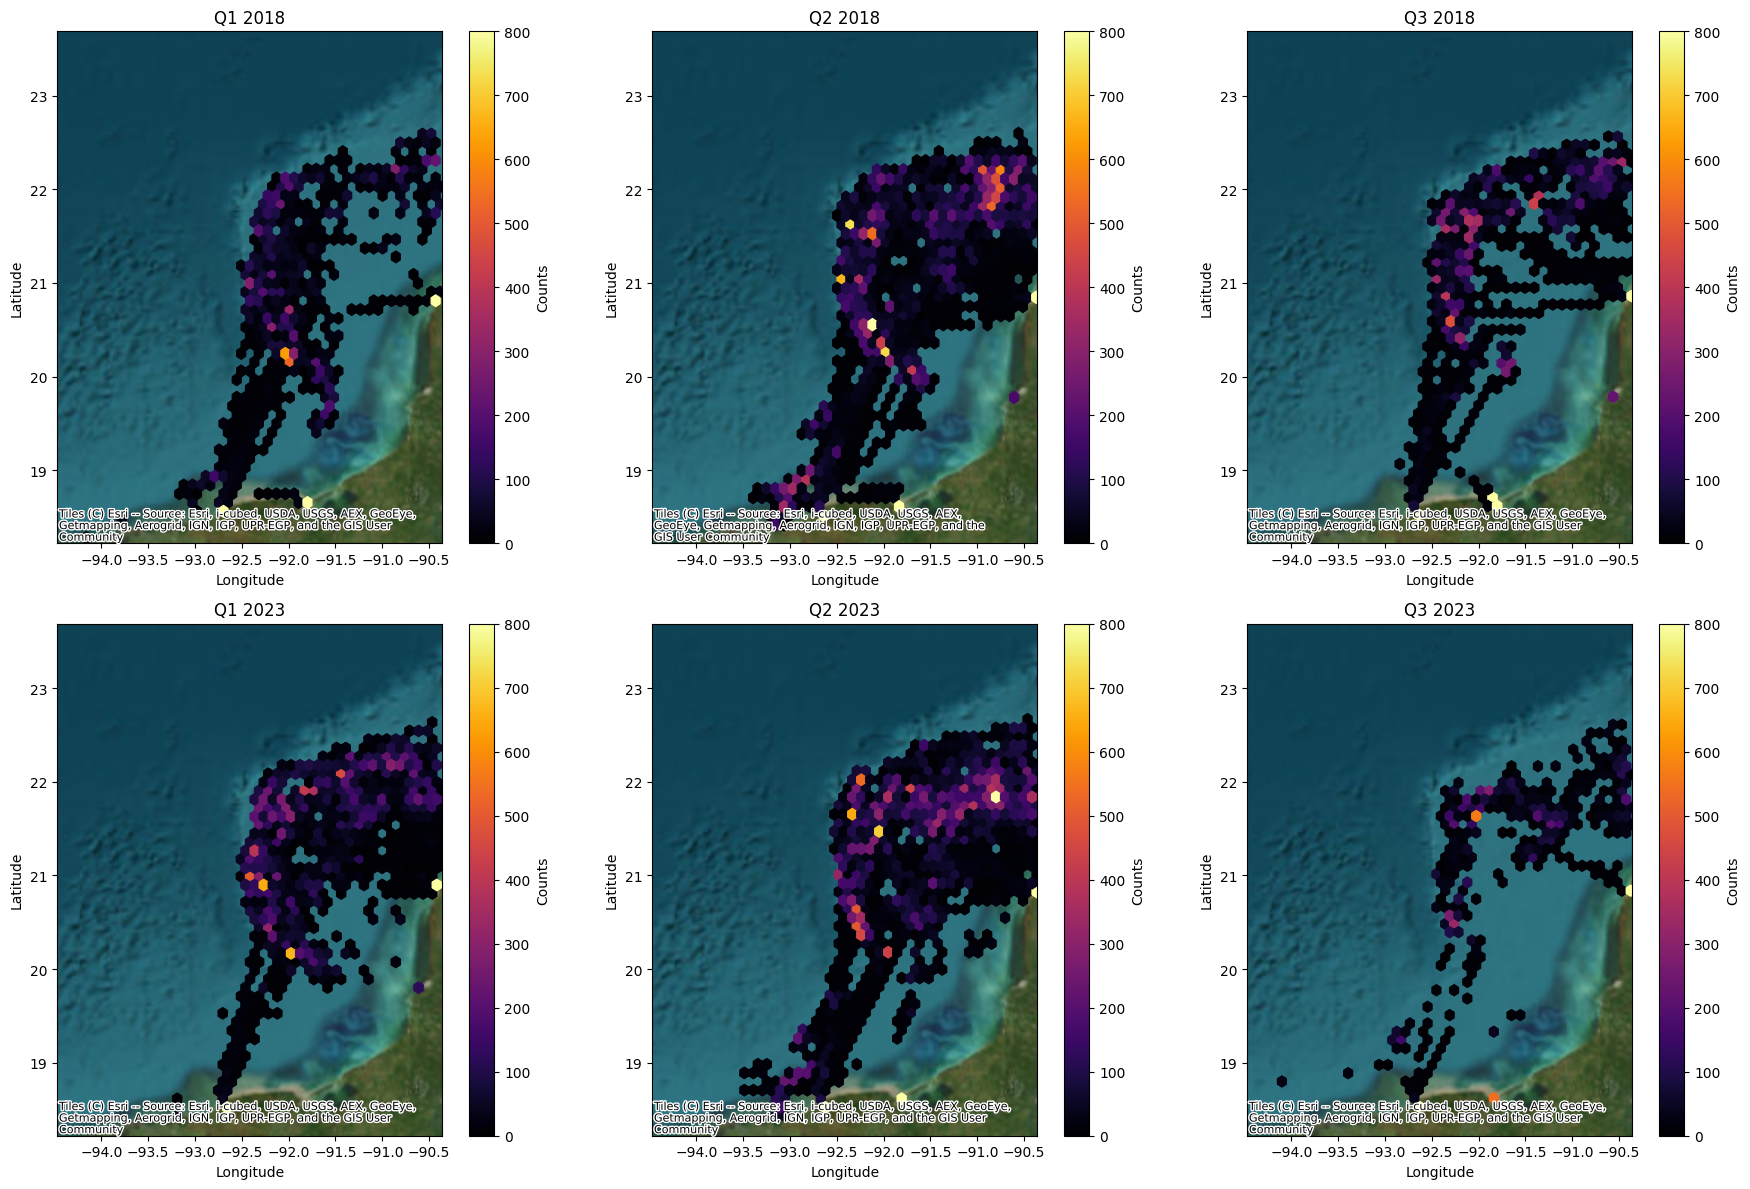

In [47]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Cargar los datos
vms_2018 = pd.read_csv('vms_tab_2018.csv')
vms_2023 = pd.read_csv('vms_tab_2023.csv')
vertices = pd.read_csv('vms_vertices.csv')

# Convertir los datos a GeoDataFrame
vms_2018['geometry'] = gpd.points_from_xy(vms_2018.Longitud, vms_2018.Latitud)
vms_2023['geometry'] = gpd.points_from_xy(vms_2023.Longitud, vms_2023.Latitud)

# Convert 'Fecha' to datetime
vms_2018['Fecha'] = pd.to_datetime(vms_2018['Fecha'])
vms_2023['Fecha'] = pd.to_datetime(vms_2023['Fecha'])

# Filter data by quarters
q1_2018 = vms_2018[vms_2018['Fecha'].dt.quarter == 1]
q2_2018 = vms_2018[vms_2018['Fecha'].dt.quarter == 2]
q3_2018 = vms_2018[vms_2018['Fecha'].dt.quarter == 3]

q1_2023 = vms_2023[vms_2023['Fecha'].dt.quarter == 1]
q2_2023 = vms_2023[vms_2023['Fecha'].dt.quarter == 2]
q3_2023 = vms_2023[vms_2023['Fecha'].dt.quarter == 3]

# Determinar los límites del mapa
minx, miny = vertices[['Longitud', 'Latitud']].min()
maxx, maxy = vertices[['Longitud', 'Latitud']].max()

# Crear la figura
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Función para crear un mapa de calor con mapa base
def heatmap(ax, x, y, title, vmin=0, vmax=800):
    hb = ax.hexbin(x, y, gridsize=40, cmap='inferno', mincnt=5, vmin=vmin, vmax=vmax)
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, zoom=6, crs='EPSG:4326')
    ax.set_title(title)
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    cb = fig.colorbar(hb, ax=ax, orientation='vertical')
    cb.set_label('Counts')

# Plotear los datos de 2018
heatmap(axes[0, 0], q1_2018.Longitud, q1_2018.Latitud, 'Q1 2018')
heatmap(axes[0, 1], q2_2018.Longitud, q2_2018.Latitud, 'Q2 2018')
heatmap(axes[0, 2], q3_2018.Longitud, q3_2018.Latitud, 'Q3 2018')

# Plotear los datos de 2023
heatmap(axes[1, 0], q1_2023.Longitud, q1_2023.Latitud, 'Q1 2023')
heatmap(axes[1, 1], q2_2023.Longitud, q2_2023.Latitud, 'Q2 2023')
heatmap(axes[1, 2], q3_2023.Longitud, q3_2023.Latitud, 'Q3 2023')

# Mostrar la figura
plt.tight_layout()
plt.show()
